# Setup
1. Go to the unity_robotics_env repo, and run "tmuxinator start -p catkin_ws/src/robotics/unity_robotics_env/mission_control.yml". This begins the ROS servers necessary for communication with the environment or a real robot running on ROS. 

# Optional - Download a model

In [1]:
# mkdir DIRNAME
# cd DIRNAME
# gsutil -m cp \ "gs://lfp_europe_west4_a/saved_models/25B0_0/checkpoint" \ "gs://lfp_europe_west4_a/saved_models/25B0_0/ckpt-12.data-00000-of-00001" \ "gs://lfp_europe_west4_a/saved_models/25B0_0/ckpt-12.index" \ .

In [1]:
gsutil -m cp "gs://lfp_europe_west4_a/saved_models/IMB002_lang_enc_obs/checkpoint" "gs://lfp_europe_west4_a/saved_models/IMB002_lang_enc_obs/ckpt-129.data-00000-of-00001" "gs://lfp_europe_west4_a/saved_models/IMB002_lang_enc_obs/ckpt-129.index" .

SyntaxError: invalid syntax (<ipython-input-1-7c4752684061>, line 1)

In [2]:
import rospy
import os, inspect

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# TODO: Images in the latent space plot, and then images on test (need to supply them as goals)

In [4]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('--bulk_datasets', nargs='+', help='data diversity dataset names')
parser.add_argument('--video_datasets', nargs='+', help='for contrastive learning')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=50, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=2048, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-lg', '--goal_mapper_layer_size', default=512, type=int, help='Layer size of goal mapping networks from im and sent to goal space, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-s_embd', '--sentence_embedding_size', default=512, type=int, help='Embedding size of MUSE sentence embeddings')
parser.add_argument('-g_embd', '--gripper_img_embedding_size', default=32, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-zg', '--goal_space_dim', default=32, type=int, help='Size of the goal embedding space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('-gi', '--gripper_images', default=False, action='store_true')
parser.add_argument('-sim', '--sim', default='Unity', help='Unity/Pybullet')
parser.add_argument('-vq', '--discrete', default=False, action='store_true')
parser.add_argument('-nm', '--normalize', default=False, action='store_true')
parser.add_argument('-lang', '--use_language', default=False, action='store_true')
parser.add_argument('-cont', '--use_contrastive', default=False, action='store_true')
parser.add_argument('-enc_all', '--encode_all', default=False, action='store_true', help='encode_actions_and_proprio not just imgs')
parser.add_argument('-sub', '--sub_out_language_percent',  type=float, default=0.25)
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP
# Set these to split the dataset up so we control the proportion of lang vs bulk vs video etc - make them batch numbers 
parser.add_argument('-ss', '--standard_split', type=int, default=0)
parser.add_argument('-bs', '--bulk_split', type=int, default=0)
parser.add_argument('-ls', '--lang_split', type=int, default=0)
parser.add_argument('-vs', '--video_split', type=int, default=0)


# args = parser.parse_args('''
# IMB0_01
# --train_dataset UR5_train
# --test_dataset UR5_test
# -tfr
# -s GCS
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 2048
# -z 256
# -lr 3e-4
# -B 0.01
# -n 5
# -i
# -gi

# '''.split())

# args = parser.parse_args('''
# 300kImB0_02
# --train_dataset envHz25
# --test_dataset envHz25_test
# -tfr
# -s GCS
# -d GPU
# -b 4
# -la 2048
# -le 512
# -lp 2048
# -z 256
# -lr 3e-4
# -B 0.02
# -n 5
# -i
# -gi

# '''.split())

args = parser.parse_args('''
B002
--train_dataset diverse
--test_dataset diverse_test
-tfr
-s GCS
-d GPU
-b 4
-la 2048
-le 512
-lp 2048
-z 256
-lr 3e-4
-B 0.02
-n 5
-i
-gi
-lang
-sub 0.0
'''.split())


# args = parser.parse_args('''
# IMB0_02_diverse
# --train_dataset envHz25
# --test_dataset envHz25_test
# -tfr
# -s GCS
# -d GPU
# -b 4
# -la 2048
# -le 512
# -lp 2048
# -z 256
# -lr 3e-4
# -B 0.02
# -n 5
# -i
# -gi
# -lang
# -sub 0.0
# --encode_all
# '''.split())

# args = parser.parse_args('''
# 300kstatesB0_04
# --train_dataset envHz25
# --test_dataset envHz25_test
# -tfr
# -s GCS
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 2048
# -z 256
# -lr 3e-4
# -B 0.02
# -n 5
# '''.split())

# -i
# -gi
# -lang

# args = parser.parse_args('''
# IMB0_00003
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# -i
# -tfr
# -wmin 10
# -wmax 40


# '''.split())

# args = parser.parse_args('''
# PROB_IM_BIGPLAN_B0_02
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -d GPU
# -b 12
# -la 2048
# -le 512
# -lp 2048
# -z 256
# -lr 3e-4
# -i
# -tfr
# -wmin 20
# -wmax 40
# -n 5


# '''.split())



# '''.split())

path = f"saved_models/{args.run_name}"    

In [5]:
# import subprocess
# def run(bashCommand):
#     process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
#     output, error = process.communicate()
# run(f"mkdir ../saved_models/{args.run_name}")

In [6]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pathlib import Path
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import data
import random
from natsort import natsorted
import lfp
import importlib
arm = 'UR5'

print('Using local setup')
WORKING_PATH = Path().absolute().parent
print(f'Working path: {WORKING_PATH}')
os.chdir(WORKING_PATH)
STORAGE_PATH = WORKING_PATH
print(f'Storage path: {STORAGE_PATH}')
np.set_printoptions(suppress=True)



Using local setup
Working path: /catkin_ws/src/robotics/learning_from_play
Storage path: /catkin_ws/src/robotics/learning_from_play


In [7]:
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

In [8]:
physical_devices = tf.config.list_physical_devices(args.device)
if args.device == 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [9]:

# hyper_params = np.load(f'{path}/hyper_params.npz', allow_pickle=True)
# scaling = hyper_params['scaling']
# for k,v in hyper_params.items():
#     print(k,v)
if args.images:
    GLOBAL_BATCH_SIZE = 4
else:
    GLOBAL_BATCH_SIZE = 256
dl = lfp.data.PlayDataloader(normalize=args.normalize, include_imgs = args.images, include_gripper_imgs = args.gripper_images, sim=args.sim, batch_size=GLOBAL_BATCH_SIZE,  window_size=args.window_size_max, min_window_size=args.window_size_min)

In [10]:

valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)
v_it = iter(valid_dataset)
# batch = trainer.make_sequences_variable_length(batch)

{   'acts': TensorSpec(shape=(4, None, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4, None), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4, None, 29), dtype=tf.float32, name=None),
    'gripper_imgs': TensorSpec(shape=(4, None, 64, 64, 3), dtype=tf.uint8, name=None),
    'imgs': TensorSpec(shape=(4, None, 128, 128, 3), dtype=tf.uint8, name=None),
    'obs': TensorSpec(shape=(4, None, 36), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(4, None, 7), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4, None), dtype=tf.int32, name=None)}


In [11]:
from importlib import reload 
reload(lfp)
reload(lfp.train)

<module 'lfp.train' from '/catkin_ws/src/robotics/learning_from_play/lfp/train.py'>

In [12]:
labelled_dl = lfp.data.labelled_dl(batch_size=GLOBAL_BATCH_SIZE, include_images = args.images, sim = args.sim)
labelled_ds = iter(labelled_dl.load(labelled_dl.extract(TEST_DATA_PATHS)))

# Load our  models

In [13]:

actor, encoder, planner, cnn, gripper_cnn,  img_embed_to_goal_space, lang_embed_to_goal_space, trainer = lfp.train.train_setup(args, dl, GLOBAL_BATCH_SIZE, strategy=None)

In [14]:
trainer.load_weights(path, from_checkpoint=True)

In [15]:
batch = labelled_ds.next()

In [16]:
if args.use_language:
    enc_policy, plan_policy, encoding, plan, indices, actions, masks, seq_lens, sentence_embeddings = trainer.step(lang_labelled_inputs = batch)

(4, 50, 32) (4, 50)


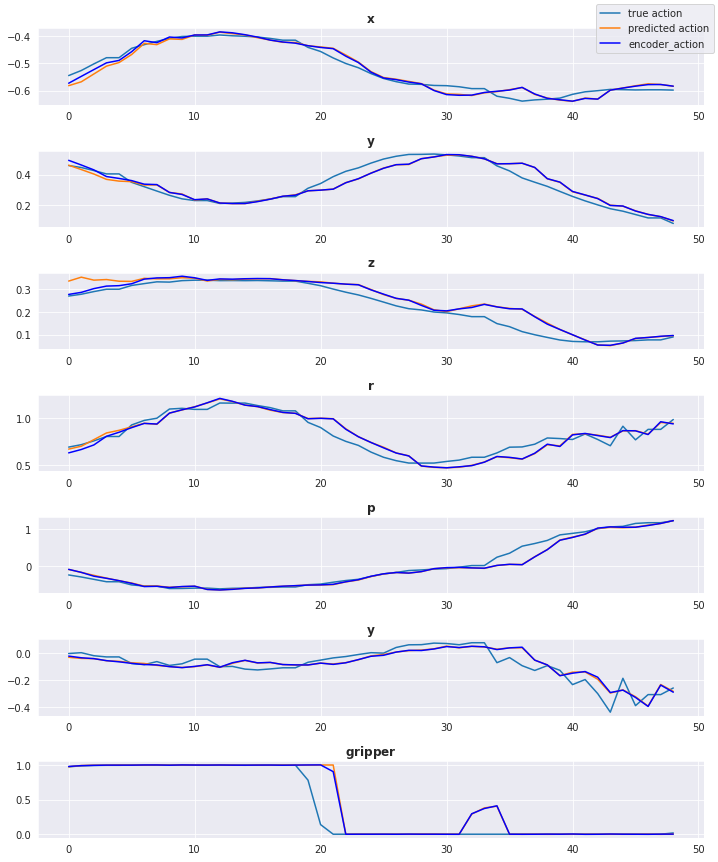

In [17]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 1
seq_len = tf.cast(batch['seq_lens'][idx], tf.int32)
x = np.arange(seq_len)
labels = ['x','y','z','r','p','y','gripper']
fig, axes = plt.subplots(dl.act_dim, 1, figsize=(10,12), squeeze=True)
for i in range(dl.act_dim):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(batch['acts'][idx,:seq_len,i])
    axes[i].plot(plan_policy[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not args.gcbc:
      sns.lineplot(x=x, y=enc_policy[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

In [18]:

labelled_dl = lfp.data.labelled_dl(batch_size=200, include_images = args.images, sim = args.sim)
labelled_ds = iter(labelled_dl.load(labelled_dl.extract(TEST_DATA_PATHS)))
big_lang_batch = labelled_ds.next()

In [19]:
batches = [trainer.make_sequences_variable_length(v_it.next()) for i in range(0,40)]
super_batch = {}
for k in batches[0].keys():
    super_batch[k] = np.concatenate([b[k] for b in batches])

In [20]:
from importlib import reload
reload(lfp)
reload(lfp.plotting)

<module 'lfp.plotting' from '/catkin_ws/src/robotics/learning_from_play/lfp/plotting.py'>

  2%|▎         | 1/40 [00:00<00:11,  3.47it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


  8%|▊         | 3/40 [00:00<00:06,  5.41it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 12%|█▎        | 5/40 [00:00<00:05,  5.96it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 18%|█▊        | 7/40 [00:01<00:05,  6.42it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 22%|██▎       | 9/40 [00:01<00:04,  6.63it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 28%|██▊       | 11/40 [00:01<00:04,  6.73it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 32%|███▎      | 13/40 [00:02<00:04,  6.70it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 38%|███▊      | 15/40 [00:02<00:03,  6.71it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 42%|████▎     | 17/40 [00:02<00:03,  6.38it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 48%|████▊     | 19/40 [00:03<00:03,  6.49it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 52%|█████▎    | 21/40 [00:03<00:02,  6.45it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 57%|█████▊    | 23/40 [00:03<00:02,  6.66it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 62%|██████▎   | 25/40 [00:03<00:02,  6.74it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 68%|██████▊   | 27/40 [00:04<00:01,  6.71it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 72%|███████▎  | 29/40 [00:04<00:01,  6.73it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 78%|███████▊  | 31/40 [00:04<00:01,  6.77it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 82%|████████▎ | 33/40 [00:05<00:01,  6.71it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 88%|████████▊ | 35/40 [00:05<00:00,  6.71it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 92%|█████████▎| 37/40 [00:05<00:00,  6.59it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 98%|█████████▊| 39/40 [00:06<00:00,  6.57it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


  2%|▏         | 1/50 [00:00<00:14,  3.35it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


  6%|▌         | 3/50 [00:00<00:08,  5.22it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 10%|█         | 5/50 [00:00<00:07,  5.64it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 14%|█▍        | 7/50 [00:01<00:07,  6.04it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 18%|█▊        | 9/50 [00:01<00:06,  6.45it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 22%|██▏       | 11/50 [00:01<00:05,  6.61it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 26%|██▌       | 13/50 [00:02<00:05,  6.49it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 30%|███       | 15/50 [00:02<00:05,  6.24it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 34%|███▍      | 17/50 [00:02<00:05,  6.02it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 38%|███▊      | 19/50 [00:03<00:04,  6.20it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 42%|████▏     | 21/50 [00:03<00:04,  6.24it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 46%|████▌     | 23/50 [00:03<00:04,  6.26it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 50%|█████     | 25/50 [00:04<00:03,  6.32it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 54%|█████▍    | 27/50 [00:04<00:03,  6.34it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 58%|█████▊    | 29/50 [00:04<00:03,  6.28it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 62%|██████▏   | 31/50 [00:05<00:02,  6.45it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 66%|██████▌   | 33/50 [00:05<00:02,  6.32it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 70%|███████   | 35/50 [00:05<00:02,  6.27it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 74%|███████▍  | 37/50 [00:05<00:01,  6.57it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 78%|███████▊  | 39/50 [00:06<00:01,  6.49it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 82%|████████▏ | 41/50 [00:06<00:01,  6.54it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 86%|████████▌ | 43/50 [00:06<00:01,  6.72it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 90%|█████████ | 45/50 [00:07<00:00,  6.51it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 94%|█████████▍| 47/50 [00:07<00:00,  6.53it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


 98%|█████████▊| 49/50 [00:07<00:00,  6.31it/s]

(4, 50, 32) (4, 50)
(4, 50, 32) (4, 50)


100%|██████████| 50/50 [00:07<00:00,  6.26it/s]
/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


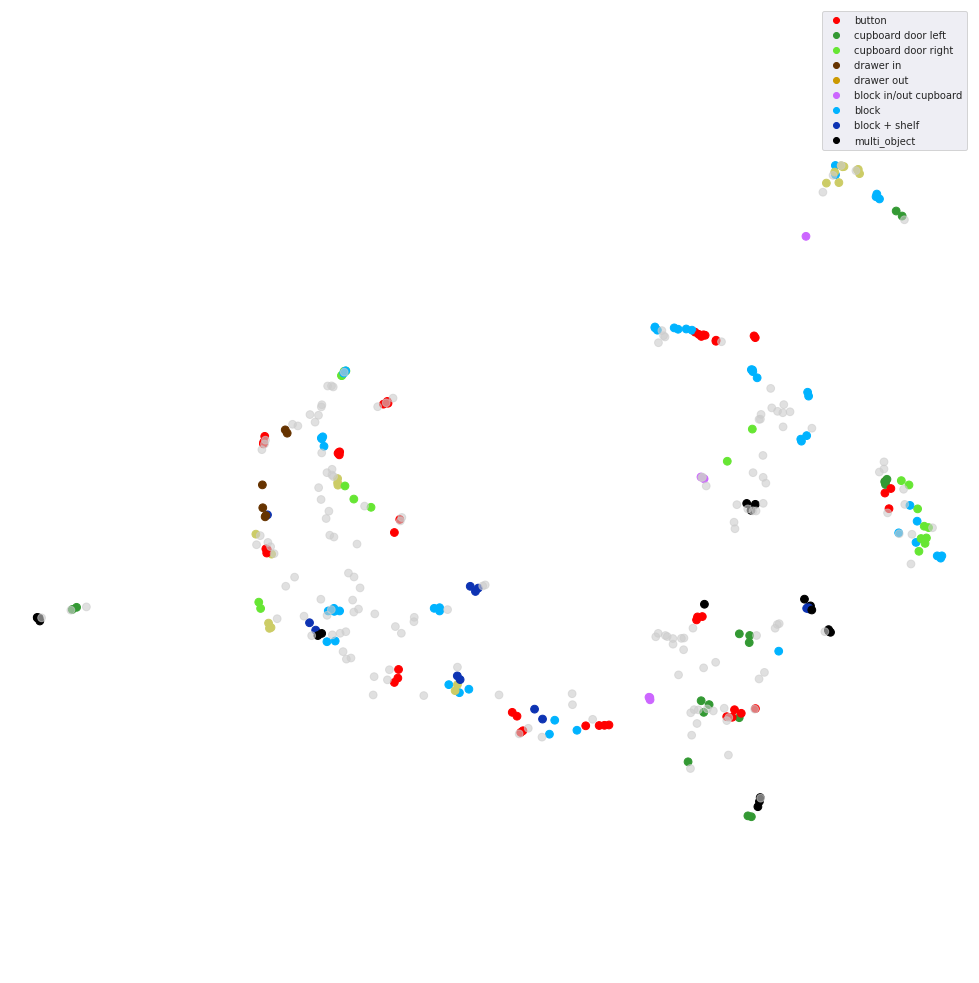

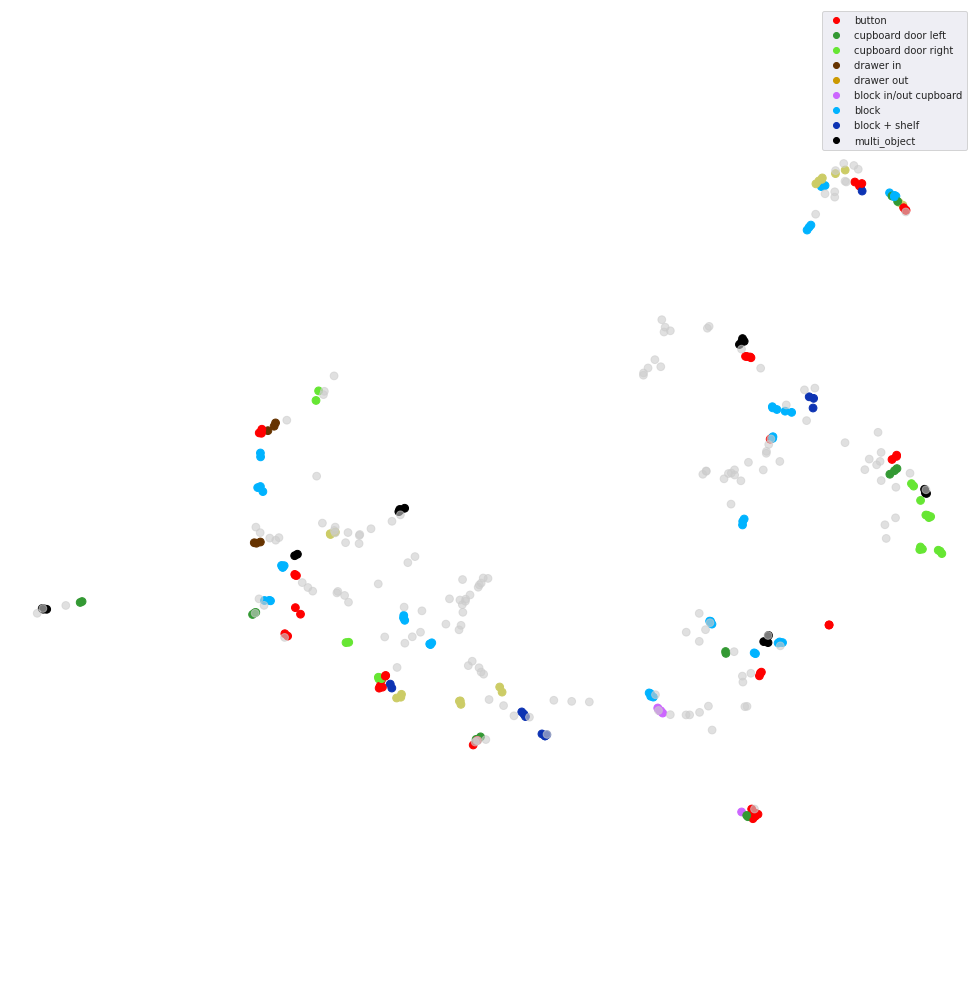

In [82]:
from lfp.plotting import produce_cluster_fig
%matplotlib inline
fig_enc, fig_plan, z_enc, z_plan = produce_cluster_fig(super_batch, big_lang_batch, trainer, args=args)

In [21]:
from lfp.plotting import project_enc_and_plan

o = project_enc_and_plan(z_enc, z_plan, connecting_lines=False)

NameError: name 'z_enc' is not defined

# Run the env

In [22]:
from importlib import reload
reload(lfp)

<module 'lfp' from '/catkin_ws/src/robotics/learning_from_play/lfp/__init__.py'>

In [23]:
from robotics_demo.msg import JointPositions, Observation, AchievedGoal, PositionCommand, RPYProprioState, Velocities, ResetInfo, ToRecord, RPYState, Reengage
from robotics_demo.srv import getIK, getIKResponse, getState, getStateResponse, getTime, getTimeResponse

from lfp.unity_utils.messaging import rosImg_to_numpy, proprio_quat_to_rpy_vector, \
        proprio_rpy_to_ROSmsg, ag_to_vector, ag_to_ROSmsg,\
        proprio_rpy_to_rpy_vector, unstack, act_to_jointPositionsROSmsg

import time
# The publisher which sends out position commands that then get converted to joint commands by the IK node
pos_cmd_pub = rospy.Publisher('xyz_rpy_g_command', PositionCommand, queue_size=1)
# The publisher which resets the non_arm elements of the state
env_reset_pub = rospy.Publisher('full_reset', ResetInfo, queue_size=1)
env_reEngage_physics_pub = rospy.Publisher('re_engage_physics', Reengage, queue_size=1)
env_reEngage_collision_pub = rospy.Publisher('re_engage_collision', Reengage, queue_size=1)
# service to get IK 
IK = rospy.ServiceProxy('get_IK', getIK)
getStateServ = rospy.ServiceProxy('getState', getState, persistent=True)
syncTimeServ = rospy.ServiceProxy('getTime', getTime, persistent=True)
rospy.init_node('jupyter2')

In [24]:

# We need to create a stateful actor
model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
                'goal_dim':args.goal_space_dim if args.images else dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':args.actor_layer_size, 
                'latent_dim':args.latent_dim,
               'training':False, 'return_state':True}

if args.gripper_images: # separate this from args.images because pybullet sim doens't have a gripper cam in the collected data
    model_params['obs_dim'] += args.gripper_img_embedding_size 

actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)

if args.use_language:
    module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    model = hub.load(module_url)
    print ("module %s loaded" % module_url)
    def embed(input):
      return model(input)
    embed = hub.KerasLayer(str(STORAGE_PATH)+'/saved_models/universal_sentence_encoder')

NameError: name 'hub' is not defined

In [25]:
trainer.actor = actor
trainer.load_weights(path, from_checkpoint=True)

In [26]:
# Step 1 - this function will constantly listen for the state, and update when it has a new observation (at 25Hz)
shoulder_image = None
ros_shoulder_image = None
gripper_image = None
ros_gripper_image = None
proprioceptive_state = None
achieved_goal = None
full_state = None
velocities = None
last_state_arrival_time = 0
last_state_processed_time = 0  # unless updated then the if check will fail because 0 is too long ago
last_vr_controller_time = 0
last_state_gen_time = 0
new_information = False

ros_shoulder_image = None
ros_gripper_image = None
    

def check_reset_convergence(proprio, ag, current_proprio, current_ag, threshold = 0.01):
    proprio_checks = abs(proprio - current_proprio) < threshold
    ag_checks = abs(ag-current_ag) < threshold
    all_checks = np.concatenate([proprio_checks, ag_checks])
    return all_checks
#     if np.all(all_checks):
#         return True
#     else:
#         return False
    
def converge_on_reset(proprio, ag, threshold = 0.05):
    global proprioceptive_state, achieved_goal
    
    t_start = time.time()
    r = rospy.Rate(10) # 10hz 
    while not rospy.is_shutdown():
        t = time.time()
        process_observation_srv() # froces a blocking updates global proprioceptive state / achieved goal
        checks = check_reset_convergence(proprio, ag, proprioceptive_state, achieved_goal, threshold)
        if (t > t_start+0.1):
            idxs = np.where(checks == False)
#             print(idxs, proprio[idxs], current_arm[idxs])
            return
        elif np.all(checks):
            return
        r.sleep() # ros sleep for a little while before checking convergence again
        
def reset_to(arm, ag, prev_act = np.zeros(7)):
    
    arm_msg, ag_msg = proprio_rpy_to_ROSmsg(arm), ag_to_ROSmsg(ag)
    # Get IK for actual position
    prev_act = JointPositions()
    
    # Package into ResetInfo
    for i in range(0,2):
        joints = IK(arm_msg, prev_act).joints # once to align it with the prev acts
        r = ResetInfo(joints, ag_msg, Velocities())
        # Send down
        env_reset_pub.publish(r)
    converge_on_reset(arm, ag, threshold = 0.05)
    env_reEngage_collision_pub.publish(Reengage())
    process_observation_srv()
    env_reEngage_physics_pub.publish(Reengage())
    
# Updates the globals, but in a blocking way so we can confirm we have the latest
def process_observation_srv(): 
    process_observation(getStateServ(int(1)).state)
    
def process_observation(o: Observation):
    '''
    The full state will be sent out at Nh > controlHz by the env, listen to it, and save the relevant parts
    '''
    global shoulder_image, gripper_image, proprioceptive_state, \
            achieved_goal, full_state, last_state_arrival_time, \
            last_state_processed_time, ros_shoulder_image, ros_gripper_image, velocities, last_state_gen_time, new_information
    last_state_gen_time = o.time
    last_state_arrival_time = time.time()
    o.shoulderImage.data += (o.imq2 + o.imq3 + o.imq4)
    ros_shoulder_image = o.shoulderImage
    shoulder_image  = rosImg_to_numpy(ros_shoulder_image)[:,:,:3]
    ros_gripper_image = o.gripperImage
    gripper_image = rosImg_to_numpy(ros_gripper_image)[:,:,:3]

    proprioceptive_state  = proprio_quat_to_rpy_vector(o.proprio)
    achieved_goal = ag_to_vector(o.ag)
    velocities = o.vels
    full_state = np.concatenate([proprioceptive_state, achieved_goal])
    last_state_processed_time = time.time()
    new_information = True
    
rospy.Subscriber("state", Observation, process_observation)

In [27]:
def flatten_obs():
    '''
    Get the right format and flatte - remeber all these are global variables implicitly updated by the subscriber
    '''
    if args.images:
        img_embedding = cnn(shoulder_image[tf.newaxis,:])
        o = tf.concat([img_embedding, proprioceptive_state[tf.newaxis,:]],axis=1)
        if args.gripper_images:
            gripper_embedding = gripper_cnn(gripper_image[tf.newaxis,:])
            o = tf.concat([o, gripper_embedding],axis=1)
    else:
        o = full_state[tf.newaxis,:] # 1,D
    return o



def choose_action(actor, o, z, g, a_true=None, t = 0):
    
    o, z, g = o[tf.newaxis,:,:], z[tf.newaxis,:,:], g[tf.newaxis,:,:] # lstm wants this shape
    a,_,_ = actor((o, z,g))
        
    a = a.sample().numpy().squeeze()
    if a_true is not None: 
        a=a_true[t, :]
    

    return a # ACT_DIM


def replan(o, goal): # O: [1,D] | goal is either a dict, list, or array lol

    
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter, letting us specify only what we want different from the rest of the env at the time we took the goal
            goal = goal['func'](*goal['args'])
            
        if args.images:
            if args.use_language and len(goal.shape) != 3: # i.e it is a sentence embeedding not a goal img
                sent_embedding = embed(goal) # 1,512
                g = lang_embed_to_goal_space(sent_embedding) # 1, G_DIM
            else:
                feature_embedding = cnn(goal[tf.newaxis,:]) # 1,128,128,3
                g = img_embed_to_goal_space(feature_embedding) # 1,G_DIM
        else:
            g = goal[tf.newaxis,:] # 1, AG_DIM
            
            
        plan = planner((o, g))
        z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        return plan, g # should be 


In [67]:
# Step 2, control loop - loop until we have new information, then act! Check for new info at 100
# Potentially include success func?

def rollout_subseq(goal, retries=1, replan_horizon=20, a_true=None, reset_state=None):
    global new_information
    t = 0
    a_pred = []
    o_observed = []
    plans = []
    
    if reset_state is not None:
        reset_to(reset_state['proprioceptive'], reset_state['achieved'])
    
    o = flatten_obs()
    z,g = replan(o, goal)
    
    if a_true is not None:
        total_steps = len(a_true)
    else:
        total_steps = retries*replan_horizon
    
    
    while not rospy.is_shutdown() and t < total_steps:
        if new_information:
            o = flatten_obs()
            if t % replan_horizon == 0:
                z,g = replan(o, goal)
            a = choose_action(actor, o, z, g, a_true, t)
            pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(a))
            
            o_observed.append(o), a_pred.append(a), plans.append(z) # record plan each timstep so we can easily see what plan it was following at any one time
            t += 1
            new_information = False
        
    return np.array(a_pred), np.squeeze(np.array(o_observed)), plans
    

# Test against trajectories from the batch

In [72]:
idx = 0
lang_batch = labelled_ds.next()
lang_batch.keys()
print(lang_batch['labels'][idx])

tf.Tensor(b'move the cupboard door right', shape=(), dtype=string)


In [ ]:

reset_state = {'proprioceptive':lang_batch['proprioceptive_features'][idx][0], 'achieved':lang_batch['obs'][idx,0,7:]}
goal =  lang_batch['goal_imgs'][idx] if args.images else lang_batch['goals'][idx, 0] # either H,W,C or D
replay_a  =  lang_batch['acts'][idx,:int(lang_batch['seq_lens'][idx]),:]
_ = rollout_subseq(goal, retries=6, a_true =None, reset_state=reset_state)

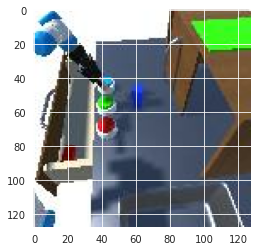

In [56]:
plt.imshow(goal)

# Test against specified goals

In [35]:
from lfp.tests import tester, tasks, success_func, tests

tester = tester(env)

kwargs = {'goal':{'func':tester.make_goal, 'args':None}, 'retries':20, 'replan_horizon':10, 'end_on_success':True, 'record_dir': None, 'reset_goal':False}

In [36]:


task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_lengthways_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
_ = env.reset()
for i, task in enumerate(task_list):
    kwargs['goal']['args'] = tasks[task]
    _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)

ValueError: Input 1 is incompatible with layer model_2: expected shape=(None, 64), found shape=(1, 11)

<module 'lfp.tests' from '/home/sholto/Desktop/AI/learning_from_play/lfp/tests.py'>

# Test against labelled trajectories from the test data examples

In [35]:
import time

from lfp.plotting import get_labelled_trajs
##############################################################################
def get_x_of_seq_type(lbl, n = 'all'):
    o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features = get_labelled_trajs(TEST_DATA_PATHS[0], args=args)
    idxs = [ i for i,x in enumerate(labels) if x == lbl]
    print(f"There are {len(idxs)} examples of '{lbl}'")
    if n == 'all':
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, idxs
    elif n == 'random':
        idx = np.random.choice(idxs)
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, [idx]
    else:
        idx = idxs[n]
        return o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, [idx]

def initialise_seq_type(g, paths, idx):

    try:
        env.delete_sub_goal()
    except:
        pass
    print(paths[idx])
    env.p.restoreState(fileName=str(paths[idx]))
    if args.images:
        plt.imshow(g[idx])
        plt.show()
        goal  =  tf.expand_dims(cnn(tf.expand_dims(g[idx], 0)),0)
    else:
        env.visualise_sub_goal(g[idx], 'achieved_goal') # if we're using images, don't viz the goal as this will change things
        goal = tf.expand_dims(tf.expand_dims(g[idx], 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    

    return goal

def test_seq_type(data, retries = 1, replay=False, replan_horizon=30):
    o, a ,g ,labels, colors, paths, imgs, goal_imgs, proprioceptive_features, idxs = data
    successes = []
    for idx in idxs:
        if args.images:
            g = goal_imgs
            
        goal = initialise_seq_type(g, paths, idx)
        a_true, o_true, traj_len = a[idx], o[idx], len(a[idx])
        a_true, a_pred, states, o_true, record_o_buff, plans, success = rollout_subseq(goal, retries, replan_horizon, a_true, o_true, traj_len,replay)
        successes.append(success)
        
    return successes 




#########################################


In [38]:
lbl = 'door right'
data = get_x_of_seq_type(lbl, n = 'all') # all, random or n

There are 15 examples of 'door right'


# Replay examples with the expert actions

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/0.bullet


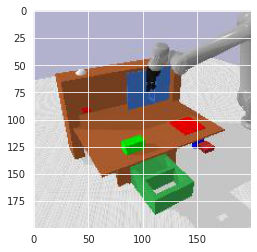

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3090.bullet


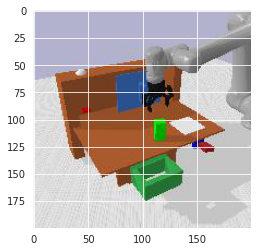

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/7170.bullet


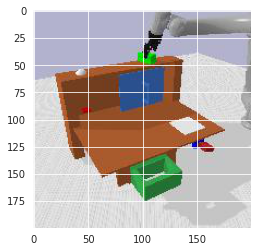

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/4440.bullet


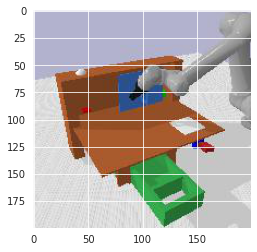

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3570.bullet


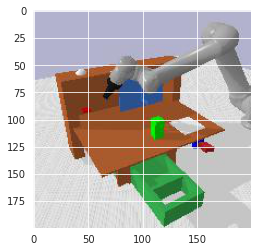

KeyboardInterrupt: 

In [39]:
successes = test_seq_type(data, retries = 1, replay=True, replan_horizon=30)

# Attempt the same trajectories

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/0.bullet


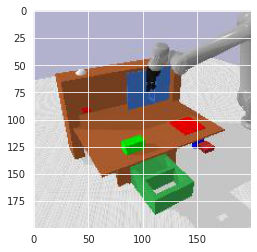

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3090.bullet


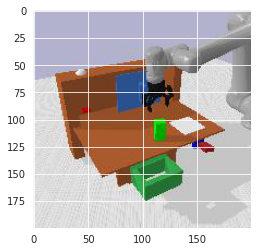

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/7170.bullet


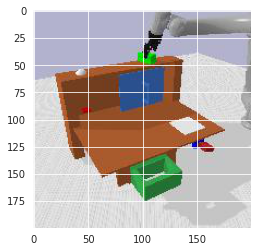

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/4440.bullet


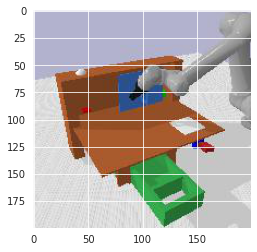

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/3570.bullet


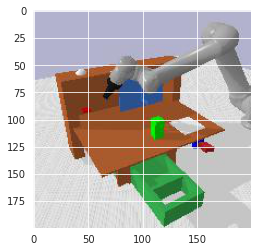

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/5880.bullet


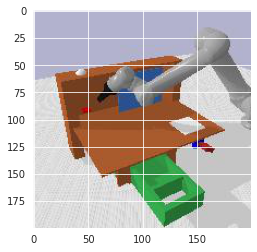

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/4740.bullet


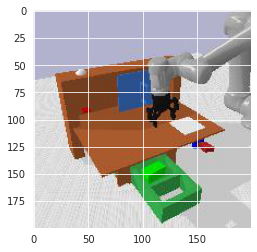

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/6060.bullet


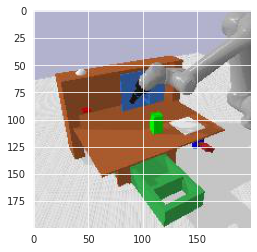

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/7980.bullet


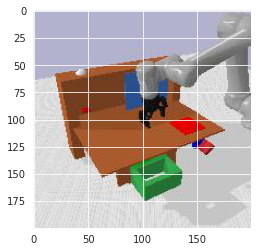

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/6870.bullet


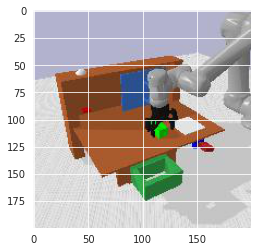

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/930.bullet


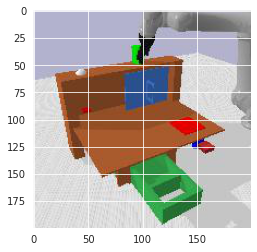

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/210.bullet


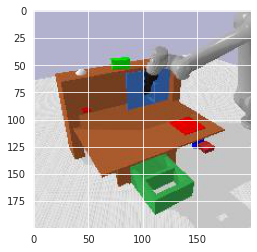

KeyboardInterrupt: 

In [41]:
successes = test_seq_type(data, retries = 10, replay=False, replan_horizon=20)

# Make recordings, and replay them while visualising the plans chosen

In [40]:
record_path = os.getcwd() + '/recordings/'

def make_recording_dir():
    demo_count = len(list(os.listdir(record_path)))
    example_path = record_path + str(demo_count)
    os.makedirs(example_path)
    return example_path


def record_state(path):
    t_step = len(list(os.listdir(path)))
    env.p.saveBullet(path +'/'+ str(t_step)) 

In [25]:

#env.render('playback') # 10 is good

In [73]:
import shutil
record_path = os.getcwd() + '/recordings/'

while len(list(os.listdir(record_path))) < 50:
    _ = env.reset()
    task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
    #task_list = [ 'block_upright']
    predicted_actions = []
    path = make_recording_dir()
    successes = 0
    for i, task in enumerate(task_list):
        kwargs['goal']['args'] = tasks[task]
        kwargs['record_dir'] = path
        _,a_pred,_,_,_,succeeded  = rollout_subseq(**kwargs)
        predicted_actions.append(a_pred)
        if succeeded:
            successes += succeeded
        else:
            break

    try:
        np.save(path + '/successes', successes)
        np.save(path + '/predicted_actions', np.vstack(predicted_actions))
        print(successes)
        if successes <= 10:
            shutil.rmtree(path)
    except:
        pass
    


8
4
11
5
4
11
11
11
6
4
6
2
7
4
9
11
2
6
2
6
11
11
12
12
10
5
11
7
4
7
8
6
4
11
5
12
12
11
7
6
11
9
11
11
6
12
9
4
6
6
4
4
6
6
0
7
0
11
11
11
3
2
8
11
7
11
12
4
11


KeyboardInterrupt: 

In [63]:

v_it = iter(valid_dataset)


# Replay and visualise plan space

In [16]:
importlib.reload(lfp)

<module 'lfp' from '/home/sholto/Desktop/AI/learning_from_play/lfp/__init__.py'>

In [42]:
import umap
reducer = umap.UMAP(metric='cosine', random_state=42)
from lfp.plotting import bucket_colors, get_labelled_trajs, hold_out, get_latent_vectors, project_labelled_latents
def establish_background(path, batch,encoder,planner,TEST_DATA_PATH, num_take, args, cnn=None, bucket=True, for_live_plotting=True):
    
    z_enc, z_plan, colors, batch_colors = get_latent_vectors(batch,encoder,planner,TEST_DATA_PATH, num_take, args, cnn, bucket)
   
    
    sampled_plans = np.load(path+'/sampled_plans.npy')
    z_space = np.concatenate([z_enc, z_plan, sampled_plans])
    reducer.fit(np.concatenate([z_enc, z_plan]))
    
    # Both the grey background dots and the labelled colored ones
    combined_colors = colors+batch_colors
    
    z_embed = reducer.transform(z_space)
    planner_embeddings = z_embed[len(z_enc):len(z_enc)+len(z_plan)] # embeddings of both the grey and colored labelled
    labelled_embeddings = z_embed[len(z_enc):len(z_enc)+len(colors)] # just the colored planner ones
    trajectory_plans = z_embed[len(z_enc)+len(z_plan):] # the ones from the trajectory we are replaying
    
    fig,scatter, ax = project_labelled_latents(planner_embeddings, combined_colors, bucket=True, figsize=(12,9)) # fig size 12,9
    
    return fig, ax, labelled_embeddings, colors, trajectory_plans

from scipy.spatial import KDTree

def plot_plan(i, labelled_embeddings, labelled_colors, trajectory_plans, past_point=None):
    plan = trajectory_plans[int(i//replan_interval)]
    tree = KDTree(labelled_embeddings)
    dd, ii = tree.query(plan, k=1) # get the nns
    spot_color = np.array(labelled_colors)[ii]# np.mean(np.array(label_colors)[ii], axis=0)
    if pp is not None:
        pp.remove()
    scatter = ax.scatter([plan[0]], [plan[1]], s=400, color = spot_color)
    plt.pause(0.01)
    
    return scatter

/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


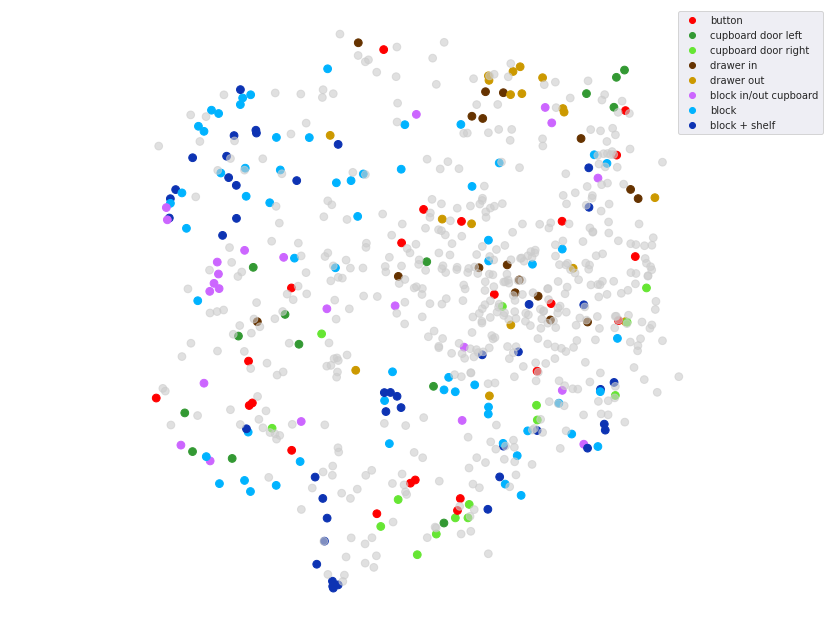

In [43]:
# This is replaying to visualise the plot 
%matplotlib qt
batch = v_it.next()
path = '/home/sholto/Desktop/AI/learning_from_play/recordings//13'
fig, ax, labelled_embeddings, labelled_colors, trajectory_plans = establish_background(path,batch, encoder, planner, TEST_DATA_PATHS[0], for_live_plotting=True, num_take=dl.batch_size, args=args, cnn=cnn)
pp = None

In [45]:

states = natsorted(list(os.listdir(path)))
states = [path+'/'+x for x in states if 'npy' not in x]
acts = np.load(path+'/predicted_actions.npy')
intervals = np.load(path+'/indices.npy')
replan_interval = len(states)/len(trajectory_plans)


time.sleep(1.0)
for i,s in enumerate(states):
        if i % replan_interval == 0:
             pp = plot_plan(i, labelled_embeddings, labelled_colors, trajectory_plans, past_point=pp)
        env.p.restoreState(fileName = s)
        env.step(acts[i])
        
        
        env.instance.updateToggles()

KeyboardInterrupt: 

In [67]:
def replay_recording(path):
    states = natsorted(list(os.listdir(path)))
    states = [path+'/'+x for x in states if 'npy' not in x]
    acts = np.load(path+'/predicted_actions.npy')
    intervals = np.load(path+'/indices.npy')
    for i,s in enumerate(states):
#         if int(i.split('/')[-1]) > 100:
#             print(i.split('/')[-1])
            env.step(acts[i])
            env.p.restoreState(fileName = s)
            env.instance.updateToggles()
            
            


In [108]:
path = '/home/sholto/Desktop/AI/learning_from_play/recordings//2'


(61, 256)

In [103]:

replay_recording('/home/sholto/Desktop/AI/learning_from_play/recordings//2')


# Success rate 

In [ ]:
test_results = []


In [ ]:
from lfp.configs_to_test import B0003, B00003,B000003, PB02
import pandas as pd
test_names = ['dial_off']
 
    
test_names = ['door_left','button','door_right','open_drawer','close_drawer','dial_off',\
              'block_cupboard_right','block_cupboard_left','block_left',\
              'block_right','block_shelf','block_drawer',\
            'block_lengthways', 'block_ori_default','block_upright'] 
 
 
configs_to_test = [PB02, B000003]

for config in configs_to_test:
    
    args = parser.parse_args(config)
    path = f"saved_models/{args.run_name}"    
    model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
            'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
            'act_dim':dl.act_dim,
            'layer_size':args.actor_layer_size, 
            'latent_dim':args.latent_dim,
            'training':False, 'return_state':True}

    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)
    lfp.utils.load_weights(path, actor, encoder, planner, cnn)
    print(f"Loaded {args.run_name}")
    
    run_results = {'name': "R"+args.run_name}
    for i, test in enumerate(test_names):
        successes = []
        for j in range(0,30):
            _ = env.reset()
            tester.prepare_env(test)
            kwargs['goal']['args'] = tests[test]
            _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)
            successes.append(succeeded)
        print(f"{test} success rate -  {np.mean(successes)}")
        run_results[test] = np.mean(successes)
    test_results.append(run_results)
        

Checkpoint restored
Loaded PROB0_02
door_left success rate -  0.9333333333333333
button success rate -  0.9
door_right success rate -  0.9333333333333333
open_drawer success rate -  0.9666666666666667
close_drawer success rate -  0.9333333333333333
dial_off success rate -  1.0
block_cupboard_right success rate -  0.7
block_cupboard_left success rate -  0.5
block_left success rate -  0.8
block_right success rate -  0.7666666666666667
block_shelf success rate -  0.9666666666666667
block_drawer success rate -  0.3333333333333333


In [ ]:
# pd.DataFrame(test_results).to_pickle(os.getcwd()+'/experimental/Test_logs2.pkl')
# #env.arm.close()
# pd.DataFrame(test_results)

# Adversarial blocks

In [48]:
def random_point():
    x = np.random.choice([0.5, -0.5])
    y =  np.random.choice([0.5, -0.5])
    z =  np.random.choice([0.3, 0.5, 0.6])
    return [x, y, z]
def create_adversary():
    
    side = 0.03
    colcubeId = bullet_client.createCollisionShape(bullet_client.GEOM_BOX, halfExtents=[side, side, side])
    visplaneId = bullet_client.createVisualShape(bullet_client.GEOM_BOX, halfExtents=[side, side, side],
                                                 rgbaColor=[1, 1, 1, 1])
    
    block = bullet_client.createMultiBody(0.1, colcubeId, visplaneId,random_point())
    return block

def guide_adversary(block):
    x1 = np.array(bullet_client.getBasePositionAndOrientation(block)[0])
    x2 = np.array(env.instance.calc_state()['observation'][0:3])
    bullet_client.applyExternalForce(block, -1, (x2-x1)*100, [0,0,0], bullet_client.LINK_FRAME)
    #bullet_client.stepSimulation()
    
bullet_client = env.p
adversaries = []
def rollout_subseq(goal,retries=1, replan_horizon=30, a_true=None, o_true=None, traj_len=None, replay=False,end_on_success = False, record_dir=None, reset_goal=False):
    
    a_pred = []
    states = []
    record_o_buff = []
    plans = [] 
    
    state = env.instance.calc_state()
    o = flatten_obs(state, record_o_buff)
    
    success = 0 
    for b in adversaries:
        bullet_client.removeBody(b)
    for j in range(0,retries):
        
        
        
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter
            g = goal['func'](*goal['args'])
            env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')
        else:
            g = goal
        
        if args.gcbc:
            z = None
        else:
            plan = planner((o[0], g[0]))
            z = tf.expand_dims(plan.sample(),0)
            plans.append(z.numpy())
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len
            
        
        block = create_adversary()
        adversaries.append(block)
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, g, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            
            guide_adversary(block)
            # put the o here
            ag = o['achieved_goal']
            if record_dir is not None:
                record_state(record_dir)
            
            o = flatten_obs(o, record_o_buff)
            if success_func(g, ag):
                success = 1
                
        if end_on_success and success:
            return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans, success
            
        
            
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans,  success

In [49]:

task_list  = ['block_shelf']
_ = env.reset()
for i, task in enumerate(task_list):
    kwargs['goal']['args'] = tasks[task]
    _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)

KeyboardInterrupt: 

# Functions to test random validation set indices

In [25]:


def get_closest_idx(point, idxs):
    
    
    closest_idx = idxs[0]
    best_diff = max(idxs)
    for i in idxs:
        diff = abs(point - i)
        if diff < best_diff:
            closest_idx = i
            best_diff = diff
    return closest_idx

def get_closest_init_state(f, start_index):
    
    potential_start_points = glob.glob(str(TEST_DIR/'states_and_ims'/str(f)/'env_states/*.bullet'))
    print(potential_start_points)
    if config.OS == 'windows':
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATHS[0])}/states_and_ims/{str(f)}/env_states\\", "")) for x in potential_start_points]
    else:
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATHS[0])}/states_and_ims/{str(f)}/env_states/", "")) for x in potential_start_points]
        
    closest_start = get_closest_idx(int(start_index), potential_start_idxs)
    return closest_start, f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states/{closest_start}.bullet"

def get_expert_actions(data, closest_start, traj_len):
    if JOINTS:
        if RELATIVE:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:6] - data['joint_poses'][closest_start:closest_start+traj_len,:6],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis=1)
        else:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)],axis = 1)
    else:
        if QUAT:
            if RELATIVE:
                a_true = np.concatenate([data['acts'][closest_start:closest_start+traj_len,:7] - data['obs'][closest_start:closest_start+traj_len,:7], 
                                         np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis = 1)
            else:
                a_true = data['acts_quat'] 
        else:
            if RELATIVE:
                a_true = data['acts_rpy_rel'][closest_start:closest_start+traj_len,:]
            else:
                a_true = data['acts'][closest_start:closest_start+traj_len,:]
    return a_true
    
    
                
def get_true_obs(data, closest_start, traj_len):
    ''' gets the actual obs so we can test the encoder actions with them '''
    traj_len += 1 # because we need all the obs, which includes one more ob than there are actions (as that ob will be produced by the final action occuring)
    if USE_QUAT_OBS:
        o = data['obs_quat'][closest_start:closest_start+traj_len,:]
    else:
        o = data['obs'][closest_start:closest_start+traj_len,:]
    if JOINTS:
        o = np.concatenate([o, data['joints'][closest_start:closest_start+traj_len,:7]])
    
    o = tf.expand_dims(o,0)
        
    if VELOCITY:
        raise NotImplemented
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    return o
    
                


def initialise_subsequence(data):
    states, acts, goals, seq_lens, masks, pth, tsteps,_,_ = [data[k] for k in data.keys()]
    start_idx = str(int(tsteps[idx,0]))
    traj_len = len(np.where(masks[idx] == 1)[0])-1
    f = int(pth[idx,0])
    
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    #print(PYBULLET_TEST_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    closest_start, start_path = get_closest_init_state(f, start_idx)
    print(start_path)
    try:
        env.delete_sub_goal()
    except:
        pass
    env.p.restoreState(fileName=start_path)
    data = np.load(TEST_DIR+'obs_act_etc/'+str(f)+'/data.npz')
    a_true = get_expert_actions(data, closest_start, traj_len)
    o_true = get_true_obs(data, closest_start, traj_len)
    goal = data['achieved_goals'][closest_start + traj_len, :]
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    state = env.arm.calc_state()
    #print(state['achieved_goal'] - goal)
    #print(goal.shape, a_true.shape, o_true.shape, traj_len)
    return goal, a_true, o_true, traj_len, state


def test_random_subseq(data, idx, retries = 1, replay=False, replan_horizon=30):
    goal, a_true, o_true, traj_len, state = initialise_subsequence(data)
    a_true, a_pred, states, o_true, record_o_buff, _ = rollout_subseq(goal, retries , replan_horizon, a_true, o_true, traj_len, replay)
    return a_true, a_pred, states, o_true, record_o_buff


    
    